# 03_FeaturePoints — Image Feature Points / Corner Detection
**Nama:** Versa Syahputra  
**NIM:** 23525041

## 🎯 Tujuan
Deteksi titik fitur (feature points) bertujuan menemukan bagian-bagian citra 
yang memiliki **pola lokal unik** dan **stabil terhadap perubahan** seperti rotasi, 
skala, atau pencahayaan. Titik-titik ini biasanya terletak pada **sudut, ujung pola, 
atau area dengan variasi intensitas tinggi**, sehingga dapat menjadi penanda 
(strong interest points) untuk mengenali atau mencocokkan citra.

## 🧠 Teori Feature Points & Parameter Utama

### Harris Corner Detector
Metode ini bertujuan untuk mendeteksi **sudut (corner)** pada citra, 
yaitu titik di mana intensitas berubah signifikan ke dua arah ortogonal. <br>
Titik ini biasanya menandakan struktur penting seperti ujung objek, jendela, atau perpotongan tepi.

Parameter utama:
- `blockSize`: ukuran jendela lokal untuk menghitung gradien.
- `ksize`: ukuran kernel Sobel.
- `k`: konstanta sensitivitas (umumnya 0.04–0.06).

### FAST (Features from Accelerated Segment Test)
Metode ini bertujuan mendeteksi **_interest points_** secara cepat dengan membandingkan intensitas 
piksel pusat terhadap piksel-piksel sekitarnya. <br>
FAST dioptimalkan untuk kecepatan dan cocok untuk aplikasi real-time, meskipun lebih sensitif terhadap noise.

Parameter yang memengaruhi:
- `threshold`: sensitivitas perbedaan intensitas.
- `nonmaxSuppression`: menekan fitur duplikat (boolean).




## Implementasi Feature Points / Corner Detection

### Fungsi pendukung dan import module

In [2]:
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
import cv2

def show_images(images: list[np.ndarray], titles: list[str], suptitle: str) -> None:
    """
    Menampilkan beberapa gambar dengan judul yang sesuai dalam satu figure.

    Args:
        images (list[np.ndarray]): List gambar yang akan ditampilkan.
        titles (list[str]): List judul untuk setiap gambar.
        suptitle (str): Judul utama untuk seluruh figure.
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    for i in range(n):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    fig.suptitle(suptitle)
    plt.show()


### Dataset citra
Menggunakan 4 jenis gambar untuk implementasi Feature Points dan Corner Detection
- `camera`, `coins`, `checkerboard` dari `skimage.data`
- Gambar eksternal oleh Clark Van Der Beken from Pexels: https://www.pexels.com/photo/teal-and-white-striped-illustration-12981881/

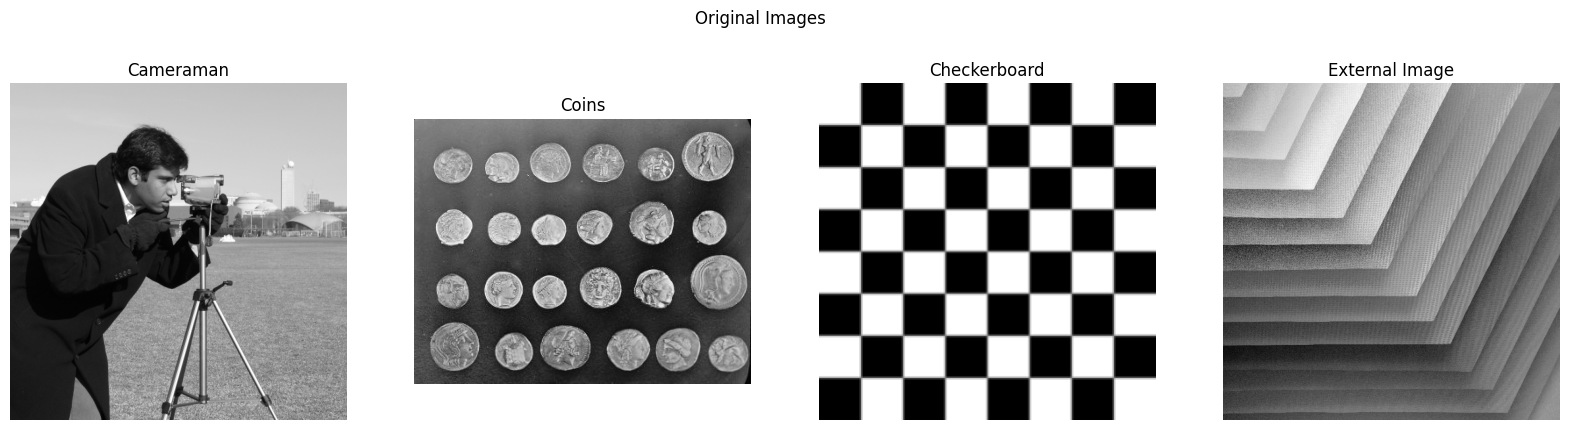

In [3]:
img_camera = data.camera()
img_coins = data.coins()
img_check = data.checkerboard()

# Gambar external
img_ext = cv2.imread("../pexels-snapsbyclark-12981881.jpg", cv2.IMREAD_GRAYSCALE)

# reduksi ukuran gambar eksternal agar sesuai
img_ext = cv2.resize(img_ext, (512, 512))

show_images(
    [img_camera, img_coins, img_check, img_ext],
    ["Cameraman", "Coins", "Checkerboard", "External Image"],
    "Original Images"
)

### Implementasi Harris Corner Detector

In [6]:
def harris_detector(gray, blockSize=2, ksize=3, k=0.04, thresh=0.01) -> tuple[np.ndarray, int]:
    """
    Fungsi untuk mendeteksi sudut (corner) pada citra menggunakan metode Harris.
    Parameter:
        gray: citra grayscale input.
        blockSize: ukuran window lokal untuk menghitung gradien.
        ksize: ukuran kernel Sobel.
        k: konstanta sensitivitas (umumnya 0.04 - 0.06).
        thresh: ambang batas untuk menentukan apakah suatu piksel adalah corner.
    Returns:
        img_marked: citra dengan penandaan corner.
        count: jumlah titik corner yang terdeteksi.
    """

    # Konversi citra menjadi tipe float32
    gray = np.float32(gray)

    # Hitung nilai Harris untuk setiap piksel
    dst = cv2.cornerHarris(gray, blockSize, ksize, k)

    # Dilasi hasil deteksi agar titik corner lebih jelas terlihat pada visualisasi
    dst = cv2.dilate(dst, None)

    # Konversi citra grayscale ke BGR agar dapat diberi warna (anotasi)
    img_marked = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Tandai piksel yang nilai Harris nya melebihi ambang (threshold)
    # Warna merah menandakan lokasi sudut yang terdeteksi
    img_marked[dst > thresh * dst.max()] = [255, 0, 0]

    # clip image dan konversi kembali ke uint8
    img_marked = np.clip(img_marked, 0, 255).astype(np.uint8)

    # Hitung jumlah piksel yang memenuhi kriteria corner
    count = np.sum(dst > thresh * dst.max())

    return img_marked, count


In [8]:
# Terapkan deteksi Harris pada gambar yang berbeda dengan default parameter
images = [img_camera, img_coins, img_check, img_ext]
results = []
counts = []
for img in images:
    marked_img, count = harris_detector(img)
    results.append(marked_img)
    counts.append(count)

# Tampilkan hasil deteksi sudut
titles = [
    f"Cameraman - Corners: {counts[0]}",
    f"Coins - Corners: {counts[1]}",
    f"Checkerboard - Corners: {counts[2]}",
    f"External Image - Corners: {counts[3]}"
]
show_images(results, titles, "Harris Corner Detection Results")



### Implementasi FAST Feature Detector

In [9]:
def fast_detector(gray, threshold=25, nonmax=True) -> tuple[np.ndarray, int]:
    """
    Fungsi untuk mendeteksi interest points menggunakan metode FAST.
    FAST bekerja dengan membandingkan intensitas piksel pusat terhadap tetangganya.
    Parameter:
        gray: citra grayscale input.
        threshold: ambang batas untuk menentukan apakah tetangga cukup berbeda.
        nonmax: boolean untuk mengaktifkan Non-Max Suppression.
    Returns:
        img_marked: citra dengan penandaan titik fitur.
        count: jumlah titik fitur yang terdeteksi.
    """

    # Inisialisasi objek detektor FAST dari OpenCV
    fast = cv2.FastFeatureDetector_create()

    # Set nilai ambang (threshold) sensitivitas deteksi
    # Semakin kecil nilai threshold, semakin banyak titik yang terdeteksi
    fast.setThreshold(threshold)

    # Aktifkan atau nonaktifkan Non-Max Suppression
    # True -> hanya simpan titik dengan respons tertinggi di area lokal
    fast.setNonmaxSuppression(nonmax)

    # Deteksi keypoints pada citra grayscale
    kp = fast.detect(gray, None)

    # Gambar keypoints di atas citra untuk visualisasi
    # Warna hijau digunakan sebagai penanda titik fitur
    img_marked = cv2.drawKeypoints(gray, kp, None, color=(0,255,0))

    # Kembalikan citra hasil marking dan jumlah titik fitur
    return img_marked, len(kp)


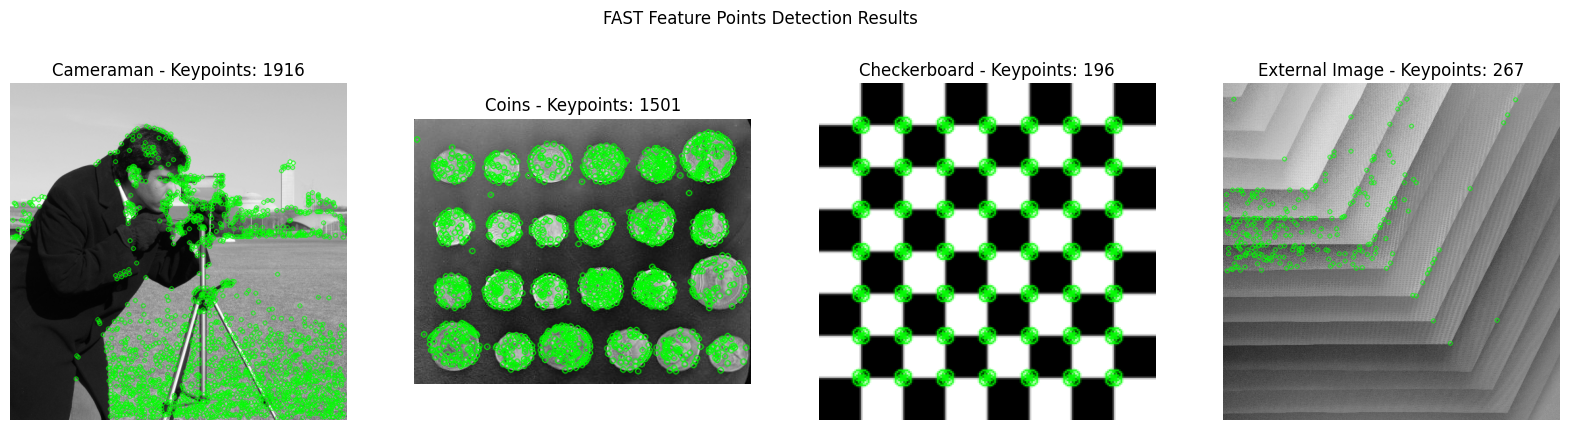

In [10]:
# Terapkan deteksi Harris pada gambar yang berbeda dengan parameter default
images = [img_camera, img_coins, img_check, img_ext]
results = []
counts = []
for img in images:
    marked_img, count = fast_detector(img)
    results.append(marked_img)
    counts.append(count)

# Tampilkan hasil deteksi titik fitur FAST
titles = [
    f"Cameraman - Keypoints: {counts[0]}",
    f"Coins - Keypoints: {counts[1]}",
    f"Checkerboard - Keypoints: {counts[2]}",
    f"External Image - Keypoints: {counts[3]}"
]
show_images(results, titles, "FAST Feature Points Detection Results")

### Eksplorasi parameter

bagian ini berfokus untuk memperlihatkan efek dari variasi parameter pada hasil Feature Points / Corner Detection.

**Tabel parameter uji untuk Harris Corner Detector**
<table>
  <tr>
    <th rowspan="1">Parameter</th>
    <th colspan="3">Values</th>
  </tr>
  <tr>
    <td>Block Size</td>
    <td>2</td>
    <td>2</td>
    <td>4</td>
  </tr>
  <tr>
    <td>Kernel Size</td>
    <td>3</td>
    <td>3</td>
    <td>3</td>
  </tr>
  <tr>
    <td>Konstanta Sensitivitas <code>k</code></td>
    <td>0.04</td>
    <td>0.06</td>
    <td>0.04</td>
  </tr>
</table>

**Tabel parameter uji untuk FAST Feature Detector**
<table>
  <tr>
    <th rowspan="1">Parameter</th>
    <th colspan="3">Values</th>
  </tr>
  <tr>
    <td>Threshold</td>
    <td>10</td>
    <td>25</td>
    <td>50</td>
  </tr>
  <tr>
    <td>Non Max Suppression</td>
    <td colspan="3"><code>True/False</code></td>
  </tr>
</table>

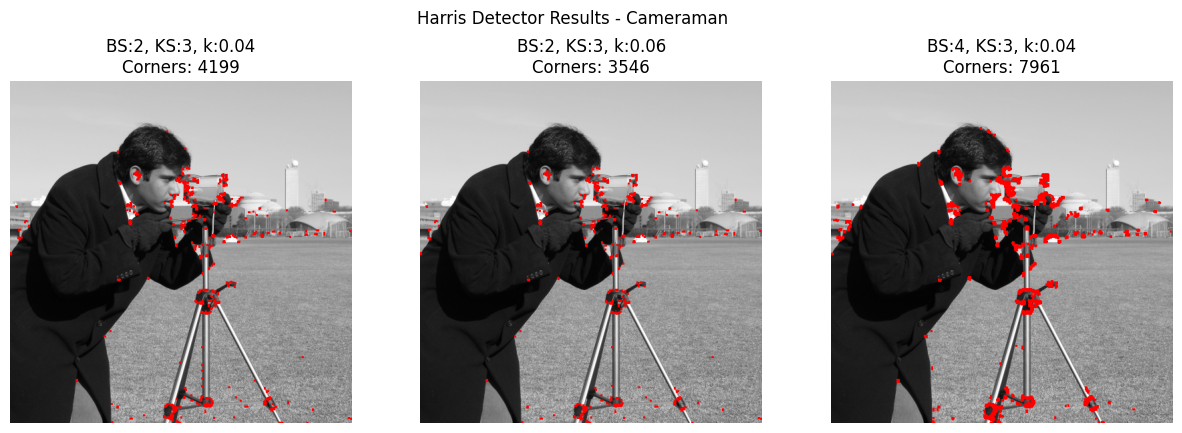

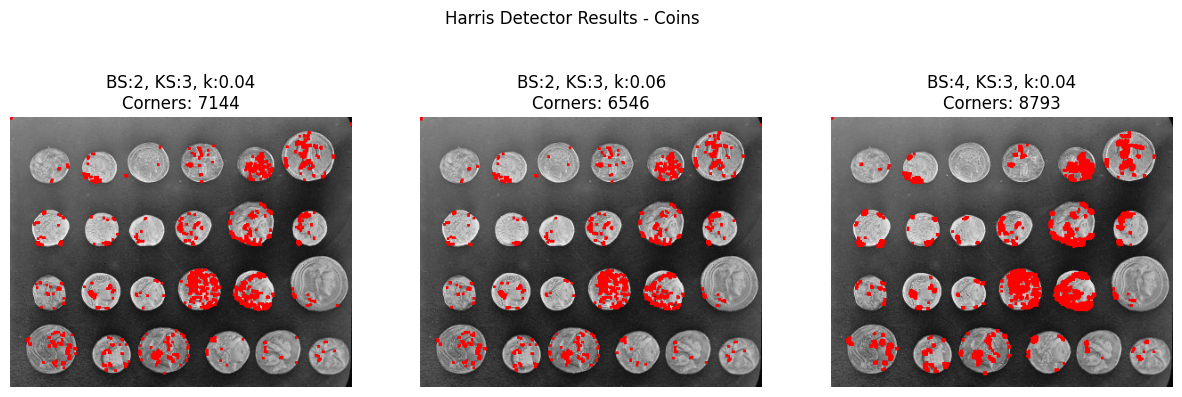

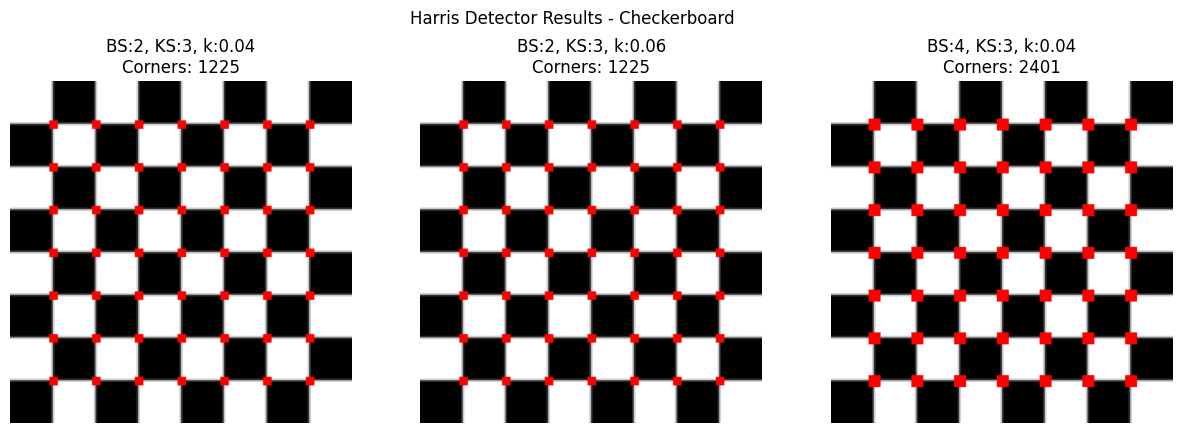

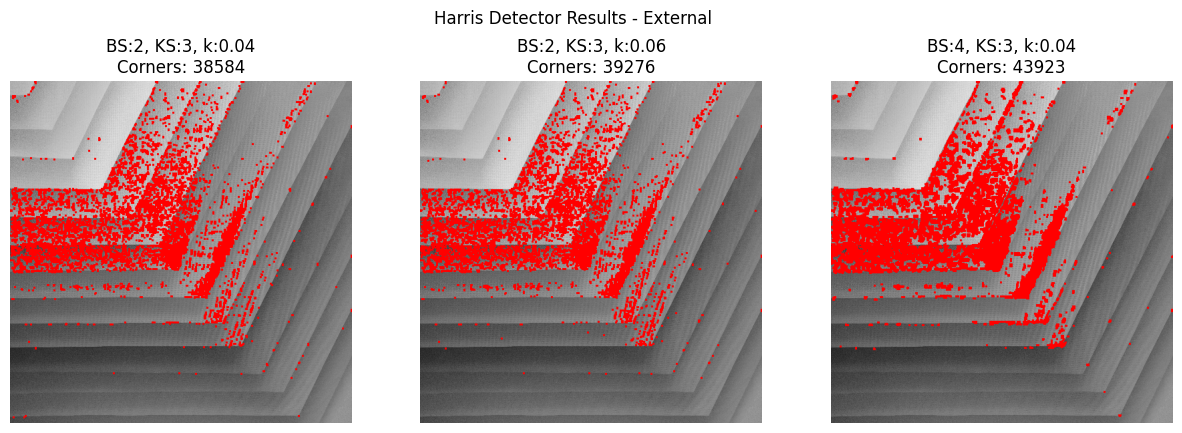

In [11]:
# eksplorasi parameter Sobel Edge Detection
res = {
    "Cameraman" : {},
    "Coins": {},
    "Checkerboard": {},
    "External": {}
}

params = [
# (Block Size, Kernel Size, k)
    (2, 3, 0.04),
    (2, 3, 0.06),
    (4, 3, 0.04),
]

for blockSize, ksize, k in params:
    for name, img in zip(res.keys(), images):
        marked_img, count = harris_detector(img, blockSize=blockSize, ksize=ksize, k=k)
        res[name][(blockSize, ksize, k)] = (marked_img, count)

# menampilkan hasil eksplorasi parameter Harris
for name in res.keys():
    images = []
    titles = []
    for (blockSize, ksize, k), (marked_img, count) in res[name].items():
        images.append(marked_img)
        titles.append(f"BS:{blockSize}, KS:{ksize}, k:{k}\nCorners: {count}")
    show_images(images, titles, f"Harris Detector Results - {name}")


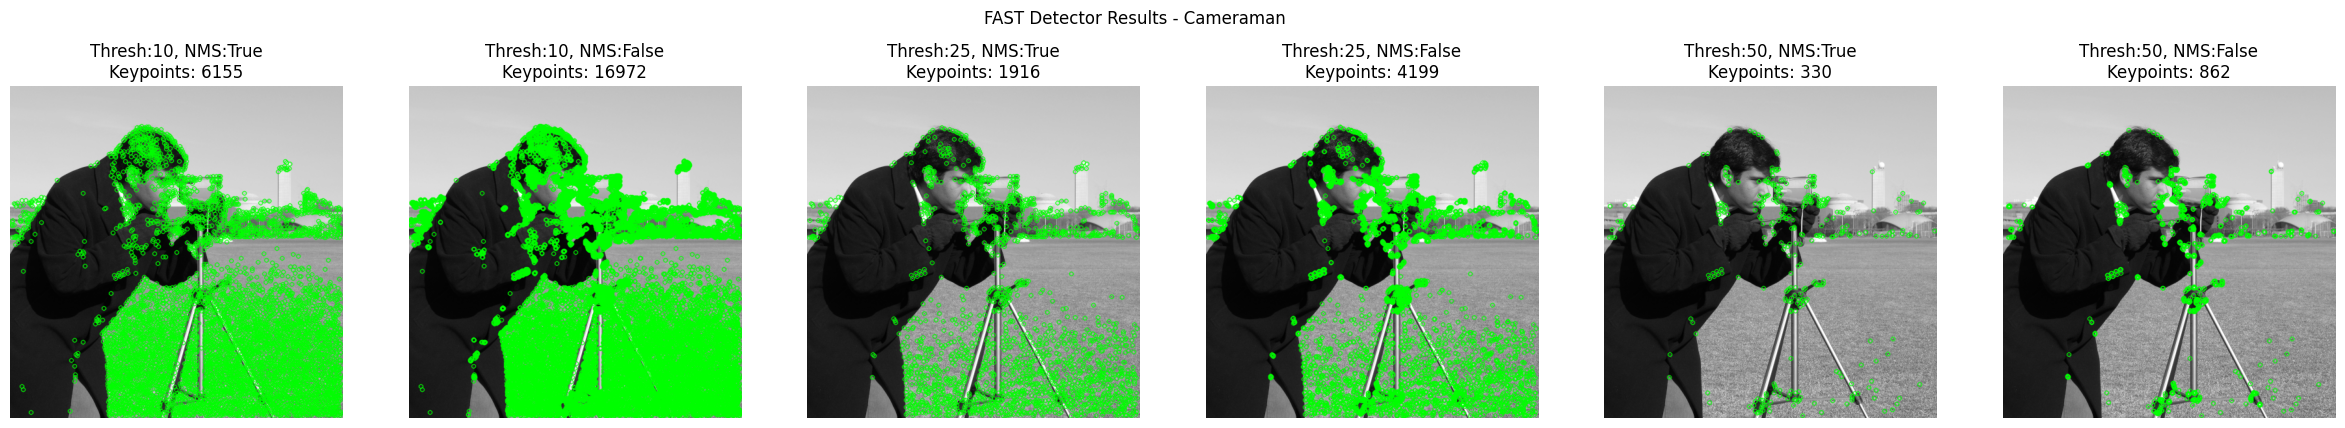

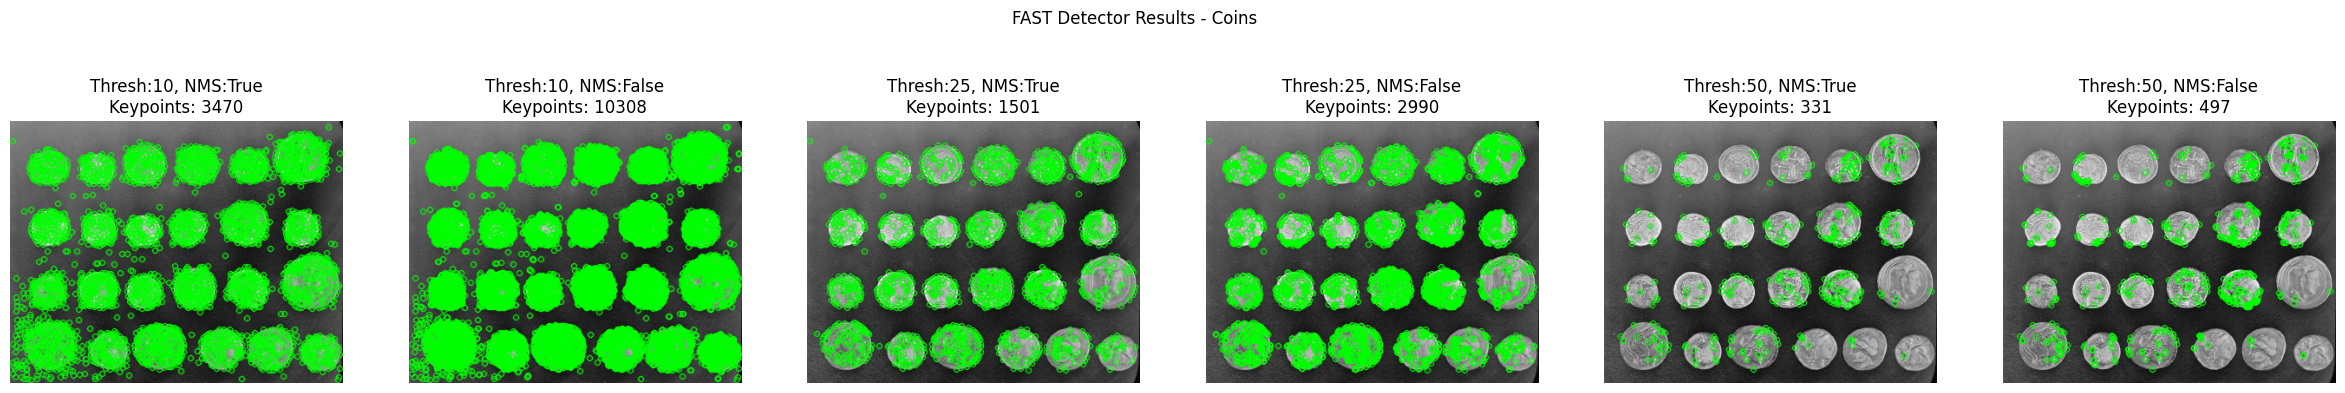

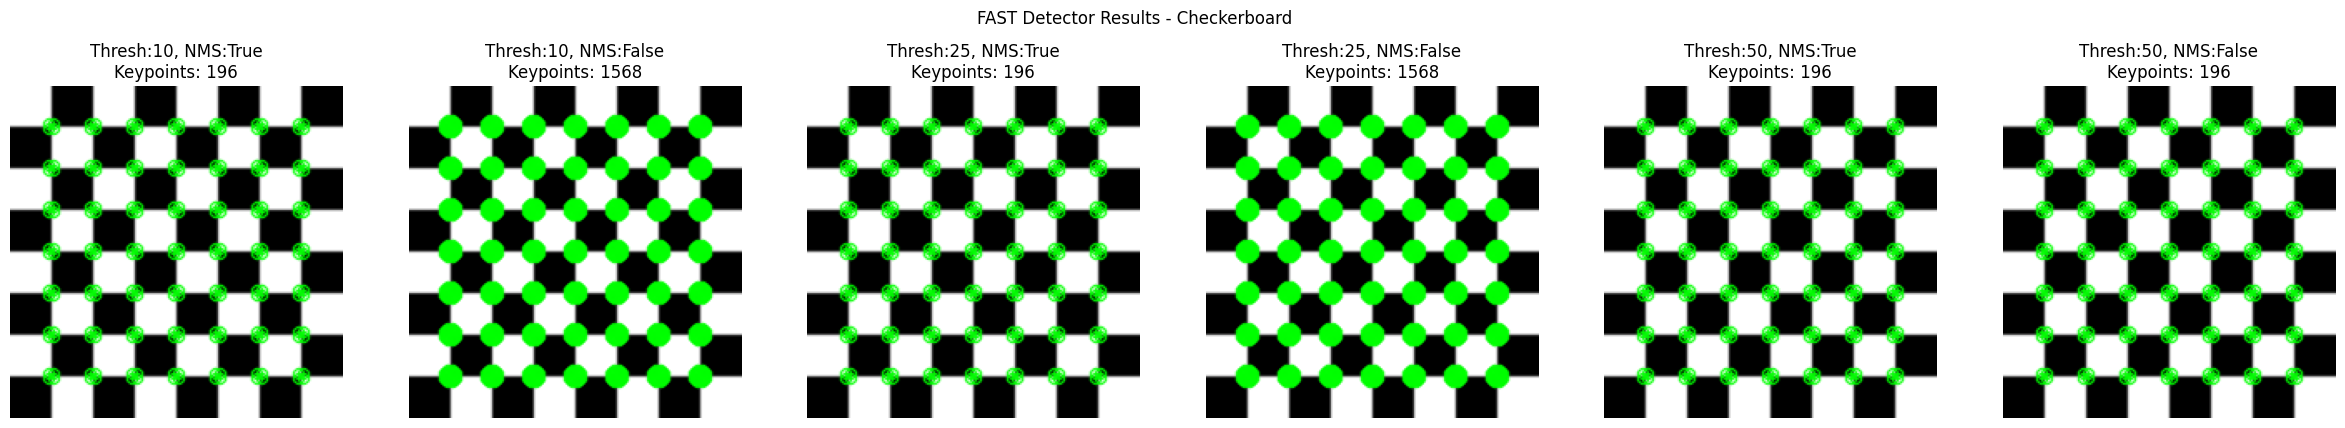

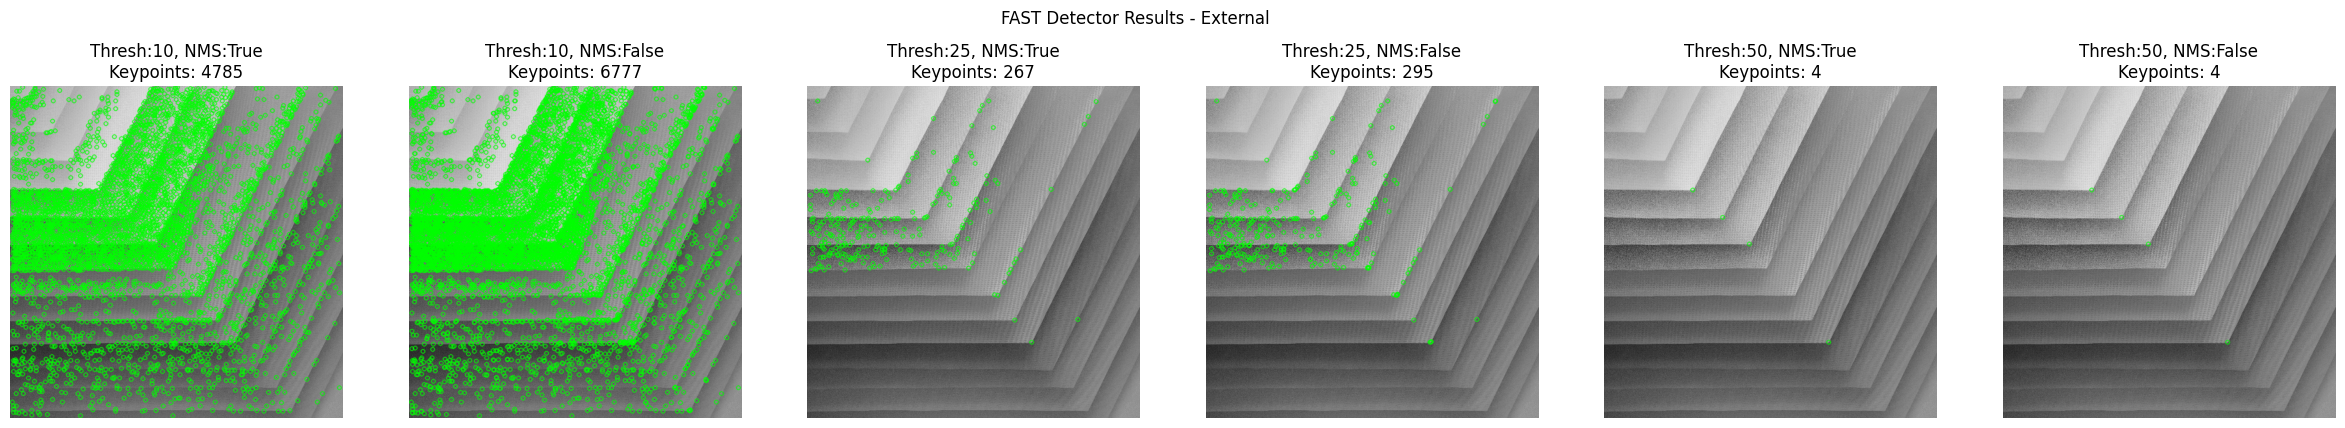

In [15]:
# Eksplorasi parameter Median filter
thresholds = [10, 25, 50]

res = {
    "Cameraman" : {},
    "Coins": {},
    "Checkerboard": {},
    "External": {}
}

images = [img_camera, img_coins, img_check, img_ext]

for thresh in thresholds:
    for name, img in zip(res.keys(), images):
        for nonmax in [True, False]:
            marked_img, count = fast_detector(img, threshold=thresh, nonmax=nonmax)
            res[name][(thresh, nonmax)] = (marked_img, count)
            
# menampilkan hasil eksplorasi parameter FAST
for name in res.keys():
    images = []
    titles = []
    for (thresh, nonmax), (marked_img, count) in res[name].items():
        images.append(marked_img)
        titles.append(f"Thresh:{thresh}, NMS:{nonmax}\nKeypoints: {count}")
    show_images(images, titles, f"FAST Detector Results - {name}")


## ✅ Kesimpulan & Analisis

Berdasarkan hasil eksplorasi parameter pada kedua metode deteksi titik fitur (Harris dan FAST), dapat disimpulkan beberapa hal berikut:

**1. Analisis Metode Harris Corner Detector**

Pada eksperimen dengan variasi parameter **block size** dan konstanta _k_, diperoleh bahwa:

- Semakin besar nilai `blockSize`, semakin banyak area lokal yang dianalisis, sehingga jumlah sudut (corner) yang terdeteksi semakin banyak. Hal ini terjadi karena area analisis yang lebih luas membuat perubahan intensitas di sekitar piksel lebih mudah terdeteksi sebagai sudut, meskipun sebagian di antaranya bisa berupa _false positive_.

- Peningkatan nilai konstanta `k` menyebabkan hasil deteksi menjadi lebih selektif, sehingga jumlah corner berkurang. Nilai `k` yang lebih tinggi membuat algoritma lebih ketat dalam menilai apakah suatu titik benar-benar memiliki perubahan intensitas yang signifikan ke dua arah ortogonal.

- Namun, pada citra checkerboard, perubahan nilai `k` hampir tidak berpengaruh signifikan terhadap jumlah corner. Hal ini disebabkan oleh pola kotak catur yang memiliki perbedaan intensitas yang sangat jelas dan teratur, sehingga sudut-sudutnya tetap kuat terdeteksi bahkan dengan parameter sensitivitas yang lebih tinggi.

- Menariknya, pada gambar eksternal, perubahan nilai `k` tidak menurunkan jumlah corner secara berarti seperti halnya pada citra camera dan coin. Kemungkinan hal ini terjadi karena distribusi tepi dan tekstur pada gambar eksternal relatif tidak kompleks, sehingga perbedaan sensitivitas `k` tidak menghasilkan variasi respons yang besar.

Secara keseluruhan, metode Harris bekerja baik untuk mendeteksi struktur geometris yang jelas seperti pada checkerboard dan camera, namun parameter perlu diatur hati-hati agar tidak terlalu banyak mendeteksi area kontras lemah sebagai corner.

**2. Analisis Metode FAST Feature Detector**

Eksperimen terhadap parameter **threshold** dan penggunaan **non-maximum suppression (NMS)** menunjukkan bahwa:

- Nilai `threshold` yang kecil membuat algoritma FAST menjadi sangat sensitif terhadap perbedaan intensitas, sehingga banyak keypoints terdeteksi, termasuk yang berasal dari noise.

- Sebaliknya, `threshold` yang terlalu besar membuat algoritma melewatkan banyak area potensial, bahkan dapat gagal mendeteksi fitur sama sekali. Hal ini terlihat jelas pada gambar eksternal, di mana hanya empat keypoint terdeteksi ketika `threshold = 50`, sementara lebih dari empat ribu titik terdeteksi pada `threshold = 10`.

- Penggunaan `Non-Max Suppression (NMS)` juga berpengaruh penting terhadap hasil deteksi. Tanpa NMS, beberapa keypoint yang berdekatan (pada area kontras tinggi) akan dianggap fitur terpisah, sehingga jumlah total titik meningkat karena terjadi duplikasi deteksi pada area yang sama.

Dengan demikian, metode FAST cenderung lebih cepat dan praktis dibanding Harris, tetapi lebih sensitif terhadap parameter `threshold` dan lebih mudah terpengaruh oleh noise jika tidak disertai NMS. Pemilihan parameter yang tepat menjadi kunci agar jumlah fitur tidak berlebihan sekaligus tetap representatif terhadap struktur citra.